# Analyze data using ilastik
The notebook shows how load images contained in a dataset
from OMERO as numpy arrays and analyze them in [ilastik](https://www.ilastik.org/).
The images are taken from  the paper "NesSys: a novel method for accurate nuclear segmentation in 3D" published August 2019 in PLOS Biology: https://doi.org/10.1371/journal.pbio.3000388

The images can be viewed online in the [Image Data Resource](https://idr.openmicroscopy.org/webclient/?show=project-801).

It assumes that ilastik project is linked to the dataset.
The 5D-numpy array is in the order expected by the ilastik project.
The order might need to be adjusted depending on the ilastik project.

### Insert required packages

In [2]:
import numpy
import os
import itertools

import tempfile
import omero.clients
from omero.gateway import BlitzGateway
from getpass import getpass

from ilastik import app
from ilastik.applets.dataSelection.opDataSelection import PreloadedArrayDatasetInfo
import vigra
import ipywidgets as widgets

### Create a connection to an OMERO server

In [3]:
HOST = 'wss://workshop.openmicroscopy.org/omero-ws'
conn = BlitzGateway(input("Username: "),
                    getpass("OMERO Password: "),
                    host=HOST, secure=True)
print(conn.connect())
conn.c.enableKeepAlive(60)

Username: trainer-1
OMERO Password: ········
True


### Enter the dataset ID

In [4]:
dataset_id = 6210

### Load the ilastik projects linked to the dataset

In [5]:
def load_model(dataset_id):
    path = tempfile.mkdtemp()
    if not os.path.exists(path):
        os.makedirs(path)
    dataset = conn.getObject("Dataset", dataset_id)
    # Go through all the annotations on the Dataset
    options = []
    for ann in dataset.listAnnotations():
        if isinstance(ann, omero.gateway.FileAnnotationWrapper):
            name = ann.getFile().getName()
            # Select the ilatisk project TODO: use namespace
            if name.endswith(".ilp"):
                file_path = os.path.join(path, name)
                options.append((name, file_path))
                with open(str(file_path), 'wb') as f:
                    for chunk in ann.getFileInChunks():
                        f.write(chunk)
    return widgets.Dropdown(options=options, disabled=False)

### Helper function: load an Image as 5D-numpy array: order TZYXC

In [6]:
def load_numpy_array(image):
    pixels = image.getPrimaryPixels()
    size_z = image.getSizeZ()
    size_c = image.getSizeC()
    size_t = image.getSizeT()
    size_y = image.getSizeY()
    size_x = image.getSizeX()
    z, t, c = 0, 0, 0  # first plane of the image

    zct_list = []
    for t in range(size_t):
        for c in range(size_c):  # all channels
            for z in range(size_z):  # get the Z-stack
                zct_list.append((z, c, t))

    values = []
    # Load all the planes as YX numpy array
    planes = pixels.getPlanes(zct_list)
    all_planes = numpy.stack(list(planes))
    shape = (size_t, size_z, size_y, size_x, size_c)
    return numpy.reshape(all_planes, newshape=shape)



In [7]:
def plane_gen():
    """
    Set up a generator of 2D numpy arrays.

    The createImage method below expects planes in the order specified here
    (for z.. for c.. for t..)

    """

    size_z = data.shape[0]-1
    for z in range(data.shape[0]):  # all Z sections data.shape[0]
        print('z: %s/%s' % (z, size_z))
        for c in range(data.shape[1]):  # all channels
            for t in range(data.shape[2]):  # all time-points
                yield data[z][c][t]

### Select the ilastik project to use.

In [8]:
model_selection = load_model(dataset_id)
display(model_selection)

Dropdown(options=(('ilastik14-Nov-2024.ilp', '/var/folders/74/13j9m56j0l7cxdczjrykzqt40000gn/T/tmpwaqj2cze/ila…

### Load each image as an 5D-numpy array and analyze.
Save the probabilities as an OMERO image

In [10]:
# Load the model linked to the dataset
model_file = model_selection.value

images = conn.getObjects('Image', opts={'dataset': dataset_id})

# Create a new dataset where to upload the generated images
dataset_obj = omero.model.DatasetI()
v = "ilastik_probabilities_from_dataset_%s" % dataset_id
dataset_obj.setName(omero.rtypes.rstring(v))
v = "ilatisk results probabilities from Dataset:%s" % dataset_id
dataset_obj.setDescription(omero.rtypes.rstring(v))
dataset_obj = conn.getUpdateService().saveAndReturnObject(dataset_obj)

# Prepare ilastik
os.environ["LAZYFLOW_THREADS"] = "2"
os.environ["LAZYFLOW_TOTAL_RAM_MB"] = "2000"
args = app.parse_args([])
args.headless = True
args.project = model_file
shell = app.main(args)

# Analyse 2 images to speed up the process
images = itertools.islice(images, 2) 
for image in images:
    filename, file_extension = os.path.splitext(image.getName())
    input_data = load_numpy_array(image)

    # run ilastik headless
    print('running ilastik using %s and %s' % (model_file, image.getName()))
    role_data_dict = [ {"Raw Data": PreloadedArrayDatasetInfo(preloaded_array=input_data, axistags=vigra.defaultAxistags("tzyxc"))}]

    predictions = shell.workflow.batchProcessingApplet.run_export(role_data_dict, export_to_array=True)
    # Save the probabilities file to the image
    print("Saving Probabilities as an Image in OMERO")
    name = filename + "_Probabilities"
    desc = "ilastik probabilities from Image:%s" % image.getId()
    for data in predictions:
        # Re-organise array from tzyxc to zctyx order expected by OMERO
        data = data.swapaxes(0, 1).swapaxes(3, 4).swapaxes(2, 3).swapaxes(1, 2)
        conn.createImageFromNumpySeq(plane_gen(), name,
                                     data.shape[0], data.shape[1],
                                     data.shape[2], description=desc,
                                     dataset=dataset_obj)
        data_viewer = data[:, 0, 0, :, :]

print("done")


INFO ilastik.app: Using tiktorch executable: ['/Users/jmarie/opt/anaconda3/envs/imaging_course_ilastik/bin/python', '-m', 'tiktorch.server']


INFO:ilastik.app:Using tiktorch executable: ['/Users/jmarie/opt/anaconda3/envs/imaging_course_ilastik/bin/python', '-m', 'tiktorch.server']


INFO ilastik.app: config file location: <none>


INFO:ilastik.app:config file location: <none>


INFO ilastik.app: Starting ilastik from /Users/jmarie/opt/anaconda3/envs/imaging_course_ilastik/lib/python3.9


INFO:ilastik.app:Starting ilastik from /Users/jmarie/opt/anaconda3/envs/imaging_course_ilastik/lib/python3.9


Starting ilastik from /Users/jmarie/opt/anaconda3/envs/imaging_course_ilastik/lib/python3.9
INFO ilastik.app: Resetting lazyflow thread pool with 2 threads.


INFO:ilastik.app:Resetting lazyflow thread pool with 2 threads.


INFO ilastik.app: Configuring lazyflow RAM limit to 2.0GiB


INFO:ilastik.app:Configuring lazyflow RAM limit to 2.0GiB


INFO lazyflow.utility.memory: Available memory set to 2.0GiB


INFO:lazyflow.utility.memory:Available memory set to 2.0GiB
WARNING 2024-11-01 11:40:55,043 opConservationTracking 11040 8638825984 Could not find any ILP solver
WARNING 2024-11-01 11:40:55,054 opStructuredTracking 11040 8638825984 Could not find any ILP solver
WARNING 2024-11-01 11:40:55,056 structuredTrackingWorkflow 11040 8638825984 Could not find any learning solver. Tracking will use flow-based solver (DPCT). Learning for tracking will be disabled!


INFO ilastik.shell.projectManager: Opening Project: /var/folders/74/13j9m56j0l7cxdczjrykzqt40000gn/T/tmpe7q5zoa7/ilastik14-Nov-2024.ilp


INFO:ilastik.shell.projectManager:Opening Project: /var/folders/74/13j9m56j0l7cxdczjrykzqt40000gn/T/tmpe7q5zoa7/ilastik14-Nov-2024.ilp


INFO omero.gateway: Registered 8cf8618e-cc08-4039-8089-1ddc8908d230/244ed0a8-c8e7-4550-aa3f-472df655626bomero.api.RawPixelsStore -t -e 1.1:tcp -h 172.17.0.1 -p 46687 -t 60000:tcp -h 134.36.5.185 -p 46687 -t 60000


INFO:omero.gateway:Registered 8cf8618e-cc08-4039-8089-1ddc8908d230/244ed0a8-c8e7-4550-aa3f-472df655626bomero.api.RawPixelsStore -t -e 1.1:tcp -h 172.17.0.1 -p 46687 -t 60000:tcp -h 134.36.5.185 -p 46687 -t 60000


INFO omero.gateway: Unregistered 8cf8618e-cc08-4039-8089-1ddc8908d230/244ed0a8-c8e7-4550-aa3f-472df655626bomero.api.RawPixelsStore -t -e 1.1:tcp -h 172.17.0.1 -p 46687 -t 60000:tcp -h 134.36.5.185 -p 46687 -t 60000


INFO:omero.gateway:Unregistered 8cf8618e-cc08-4039-8089-1ddc8908d230/244ed0a8-c8e7-4550-aa3f-472df655626bomero.api.RawPixelsStore -t -e 1.1:tcp -h 172.17.0.1 -p 46687 -t 60000:tcp -h 134.36.5.185 -p 46687 -t 60000


running ilastik using /var/folders/74/13j9m56j0l7cxdczjrykzqt40000gn/T/tmpe7q5zoa7/ilastik14-Nov-2024.ilp and B1_C1.tif
DEBUG lazyflow.operators.classifierOperators.OpBaseClassifierPredict: classifier changed, setting dirty


DEBUG:lazyflow.operators.classifierOperators.OpBaseClassifierPredict:classifier changed, setting dirty


DEBUG lazyflow.operators.classifierOperators.OpBaseClassifierPredict: classifier changed, setting dirty


DEBUG:lazyflow.operators.classifierOperators.OpBaseClassifierPredict:classifier changed, setting dirty


DEBUG lazyflow.operators.classifierOperators.OpBaseClassifierPredict: classifier changed, setting dirty


DEBUG:lazyflow.operators.classifierOperators.OpBaseClassifierPredict:classifier changed, setting dirty


DEBUG lazyflow.operators.classifierOperators.OpBaseClassifierPredict: classifier changed, setting dirty


DEBUG:lazyflow.operators.classifierOperators.OpBaseClassifierPredict:classifier changed, setting dirty


INFO ilastik.applets.batchProcessing.batchProcessingApplet: Exporting to in-memory array.


INFO:ilastik.applets.batchProcessing.batchProcessingApplet:Exporting to in-memory array.


INFO lazyflow.utility.bigRequestStreamer: Estimated RAM usage per pixel is 120.0B * safety factor (2.0)


INFO:lazyflow.utility.bigRequestStreamer:Estimated RAM usage per pixel is 120.0B * safety factor (2.0)


INFO lazyflow.utility.bigRequestStreamer: determining blockshape assuming available_ram is 1.5GiB, split between 2 threads


INFO:lazyflow.utility.bigRequestStreamer:determining blockshape assuming available_ram is 1.5GiB, split between 2 threads


INFO lazyflow.utility.bigRequestStreamer: Chose blockshape: (1, 149, 148, 148, 2)


INFO:lazyflow.utility.bigRequestStreamer:Chose blockshape: (1, 149, 148, 148, 2)


INFO lazyflow.utility.bigRequestStreamer: Estimated RAM usage per block is 747.0MiB


INFO:lazyflow.utility.bigRequestStreamer:Estimated RAM usage per block is 747.0MiB


DEBUG lazyflow.operators.classifierOperators: Features took 3.940141 seconds. Prediction took 2.934269 seconds. Subregion: start '[0, 0, 0, 0]' stop '[149, 148, 148, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 3.940141 seconds. Prediction took 2.934269 seconds. Subregion: start '[0, 0, 0, 0]' stop '[149, 148, 148, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 5.22452 seconds. Prediction took 3.959571 seconds. Subregion: start '[0, 0, 148, 0]' stop '[149, 148, 271, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 5.22452 seconds. Prediction took 3.959571 seconds. Subregion: start '[0, 0, 148, 0]' stop '[149, 148, 271, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 3.046419 seconds. Prediction took 2.9482720000000002 seconds. Subregion: start '[0, 148, 0, 0]' stop '[149, 275, 148, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 3.046419 seconds. Prediction took 2.9482720000000002 seconds. Subregion: start '[0, 148, 0, 0]' stop '[149, 275, 148, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 4.072329 seconds. Prediction took 2.772148 seconds. Subregion: start '[0, 148, 148, 0]' stop '[149, 275, 271, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 4.072329 seconds. Prediction took 2.772148 seconds. Subregion: start '[0, 148, 148, 0]' stop '[149, 275, 271, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 3.143581 seconds. Prediction took 2.269011 seconds. Subregion: start '[149, 0, 0, 0]' stop '[236, 148, 148, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 3.143581 seconds. Prediction took 2.269011 seconds. Subregion: start '[149, 0, 0, 0]' stop '[236, 148, 148, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 2.610709 seconds. Prediction took 1.566942 seconds. Subregion: start '[149, 0, 148, 0]' stop '[236, 148, 271, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 2.610709 seconds. Prediction took 1.566942 seconds. Subregion: start '[149, 0, 148, 0]' stop '[236, 148, 271, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 2.025179 seconds. Prediction took 1.582973 seconds. Subregion: start '[149, 148, 0, 0]' stop '[236, 275, 148, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 2.025179 seconds. Prediction took 1.582973 seconds. Subregion: start '[149, 148, 0, 0]' stop '[236, 275, 148, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 2.244951 seconds. Prediction took 1.28122 seconds. Subregion: start '[149, 148, 148, 0]' stop '[236, 275, 271, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 2.244951 seconds. Prediction took 1.28122 seconds. Subregion: start '[149, 148, 148, 0]' stop '[236, 275, 271, 2]'


Saving Probabilities as an Image in OMERO
done


### View the last result 

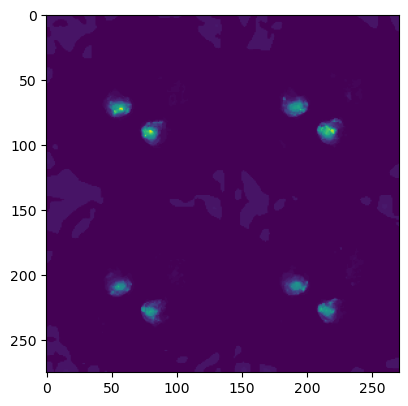

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
size = data_viewer.shape[0]

fig = plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(data_viewer[int(size/2), :, :])
fig.canvas.flush_events()

### Close the connection to the OMERO server

In [12]:
conn.close()

INFO omero.util.Resources: Halted


INFO:omero.util.Resources:Halted


INFO omero.gateway: closed connection (uuid=None)


INFO:omero.gateway:closed connection (uuid=None)


### License (BSD 2-Clause)
Copyright (C) 2019-2024 University of Dundee. All Rights Reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.
THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.